<a href="https://colab.research.google.com/github/NeZorinEgor/MachineVision-Learning/blob/main/t1000/t1000.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.transform as st
import skimage.data as data
import tensorflow as tf
import matplotlib.image as mpimg

In [37]:
def build_coefs_3c(w_gauss, cols=3, filters=3):
    w1 = build_coefs(w_gauss, cols=cols, filters=cols)
    w_zeros = np.zeros_like(w_gauss)
    w2 = build_coefs(w_zeros, cols=cols, filters=cols)
    wout = w2.copy()
    for c in range(cols):
        wout[:,:,c,c] = w1[:,:,0,0].copy()
    return wout

In [38]:
def cut_mask(mask):
    return mask[:, mask.shape[1]//2:, :, :]

In [39]:
def upsample_and_smooth(mask):
    inp = tf.keras.layers.Input(shape=(mask.shape[1], mask.shape[2], mask.shape[3]))
    y = tf.keras.layers.Conv2DTranspose(filters=COL, kernel_size=(3,3), name='conv', padding='same', use_bias=False, activation='linear', strides=(2,2))(inp)
    model_ups = tf.keras.models.Model(inputs=[inp], outputs=[y])
    model_ups.get_layer('conv').set_weights([wfils])
    return model_ups.predict(mask)*4

In [40]:
def build_coefs(w_gauss, cols=1, filters=1):
    wcols = []
    for c in range(cols):
        wcols.append(w_gauss)
    wcols = np.array(wcols)
    wcols = np.rollaxis(wcols, 0, 3)

    wfils = []
    for f in range(filters):
        wfils.append(wcols)
    wfils = np.array(wfils)
    wfils = np.rollaxis(wfils, 0, 4)
    return wfils

In [41]:
def transform_to_terminator(human_image, eye_centers, mouth_edges):
    terminator_image = mpimg.imread('terminator.jpg')
    rows, cols, dim = human_image.shape

    w_gauss = np.array([
        [1/16, 1/8, 1/16],
        [1/8, 1/4, 1/8],
        [1/16, 1/8, 1/16]
    ])

    wfils = build_coefs_3c(w_gauss)

    eye_centers_resized = [(x * 512 / cols, y * 512 / rows) for x, y in eye_centers]
    mouth_edges_resized = [(x * 512 / cols, y * 512 / rows) for x, y in mouth_edges]

    blura = [1]*6
    blura[1], blura[2], blura[3], blura[4], a, a, a, blura[5] = model_lapl.predict(
        np.expand_dims(human_image, axis=0), verbose=False
    )

    rows2 = rows // 16
    cols2 = cols // 16
    eye_centers_transformed = [(x // 16, y // 16) for x, y in eye_centers_resized]
    mouth_edges_transformed = [(x // 16, y // 16) for x, y in mouth_edges_resized]

    mask = [0] * 9
    mask[8] = np.ones(shape=(1, 4*2, 4, 3))
    mask[8][:,:,:2,:] = 0
    for i in range(7,0,-1):
        mask[i] = upsample_and_smooth(mask[i+1])
    for i in range(5,0,-1):
        mask[i] = cut_mask(mask[i])

    blur = [0] * 6
    for i in range(5, 0, -1):
        blur[i] = blura[i] * mask[i] + blurb[i] * (1 - mask[i])

    y = model_lapl_ups.predict([blur[5], blur[4], blur[3], blur[2], blur[1]], verbose=False)

    return y[0].astype(int)

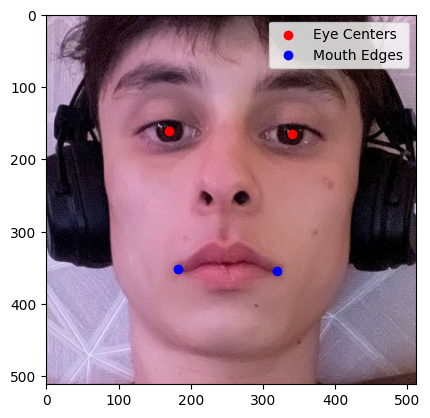

1/1 [==============================] - 0s 62ms/step


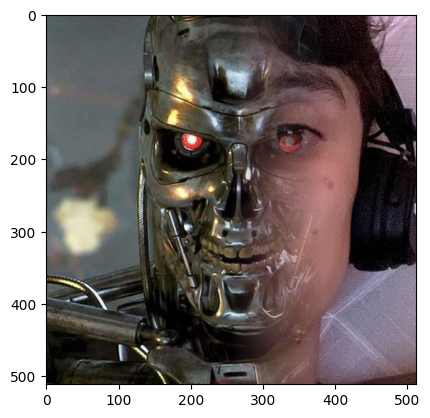

In [42]:
human_image = mpimg.imread('Egorik.jpg')[300:812, 190:702]
terminator_image = mpimg.imread('terminator.jpg')

eye_centers = [(170, 160), (340, 165)]  # Центр глаз
mouth_edges = [(182, 352), (320, 354)]  # Края рта

plt.imshow(human_image)
plt.scatter([p[0] for p in eye_centers], [p[1] for p in eye_centers], color='red', marker='o', label='Eye Centers')
plt.scatter([p[0] for p in mouth_edges], [p[1] for p in mouth_edges], color='blue', marker='o', label='Mouth Edges')
plt.legend()
plt.show()

terminator_face = transform_to_terminator(human_image, eye_centers, mouth_edges)

plt.imshow(terminator_face)
plt.show()
